# Analysis of Ou 5 central star using post-AGB tracks

Originally based on what I did for the Turtle, using Miller Bertolami 2016. But I intent to also use MIST tracks, which have a finer grid of masses


In [1]:
import numpy as np
from astropy.table import Table
from pathlib import Path

In [12]:
datadir = Path("../cspn-tables")

## Miller Bertolami tracks

In [13]:
byte_by_byte_description = """
Byte-by-byte Description of file:
--------------------------------------------------------------------------------
   Bytes Format Units     Label       Explanations
--------------------------------------------------------------------------------
   1-  5  I5    ---       N           Track point number
   7- 15  F9.6  [Lsun]    logL        logarithm of the stellar luminosity
  17- 25  F9.6  [K]       logTeff     logarithm of the effective temperature
  27- 35  F9.6  [cm/s2]   logg        logarithm of the surface gravity
  40- 51  F12.4 yr        t           Age since the point at LogTeff=3.85
  53- 61  F9.6  ---       Menv        Fractional mass of the envelope
  63- 71  F9.6  Msun      Mstar       Total mass of the star
  73- 82  F10.6 [Msun/yr] log(-dM/dt)  Logarithm of the Mass Loss Rate,
                                       log(-dMstar/dt)
--------------------------------------------------------------------------------
"""

In [14]:
def read_tracks(datafile):
    """Read each Miller–Bertolami track into a separate astropy.table
    
    Input argument `datafile` is a CDS file containing all tracks 
    for a given metallicity, e.g., "0100_t03.dat"
    
    Returns list of tables. Each table has a metadata "comments" field 
    that contains additional info (mass and surface composition). 
    """
    with open(datafile) as f:
        # Each track is separated by two blank lines
        tracks = f.read().split("\n\n\n")[:-1]
        tables = []
        for track in tracks:
            lines = track.split("\n")
            metadata = lines[:6]
            data = lines[7:]
            datastring = "\n".join(
                [byte_by_byte_description] + data
            )
            table = Table.read(datastring, format="ascii.cds")
            table.meta["comments"] = metadata
            tables.append(table)
    return tables

In [15]:
tabs = read_tracks(datadir / "miller-bertolami-2006" / "0100_t03.dat")
[_.meta for _ in tabs]

[{'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.000000     0.531867      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .701     .289     .133E-02 .105E-02 .474E-02']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.250000     0.565954      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .586     .310     .733E-01 .990E-03 .248E-01']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.500000     0.583201      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .700     .285     .503E-02 .117E-02 .592E-02']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   2.000000     0.582574      301',
   '# Surface composition:',
   '#     H      He        C     

In [16]:
10**3.589592

3886.79826324366

In [153]:
tabs[2].show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("talk")
sns.set_color_codes()

Plot of effective temperature versus gravity, which we compare with the Ou 5 observed values.

In [9]:
def extract_masses(data):
    _, Mi, Mf, _ = data.meta["comments"][2].split()
    return round(float(Mi), 2), round(float(Mf), 3)

### Kiel diagram

Make it into a Kiel diagram like in Jones+2022

In [28]:
log_g, dlog_g = 6.38, 0.08
# say 10% uncertainty in T
T, dT = 115, 10

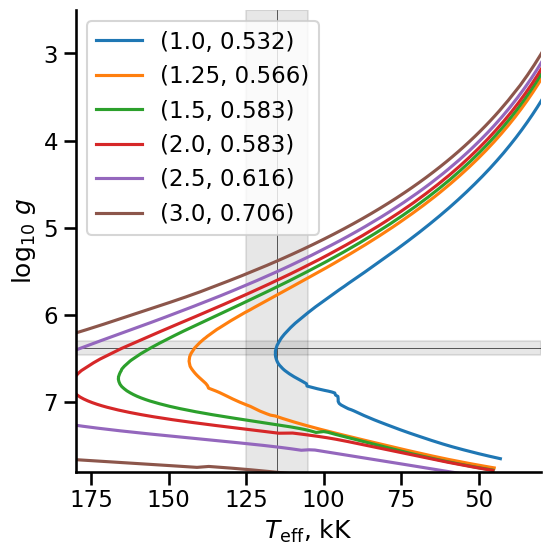

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvspan(T - dT, T + dT, color="k", alpha=0.1)
ax.axvline(T, color="k", lw=0.5)
ax.axhspan(log_g - dlog_g, log_g + dlog_g, color="k", alpha=0.1)
ax.axhline(log_g, color="k", lw=0.5)
for data in tabs:
    try:
        Mi, Mf = extract_masses(data)
        label = f"({Mi}, {Mf})"
    except:
        continue
    ax.plot(
        0.001 * 10**data["logTeff"], data["logg"],
        label=label,
    )
ax.legend()
ax.set(
    ylabel=r"$\log_{10}\, g$",
    xlabel=r"$T_{\mathrm{eff}}$, kK",
    ylim=[7.8, 2.5],
    xlim=[180, 30],
)
sns.despine()
None

From this we would conclude that the $1\,M_\odot$ model is the best fit, and it is also consistent with the gravity from the final mass of 0.5 or so

### Time evolution

Next, look at the timescales.

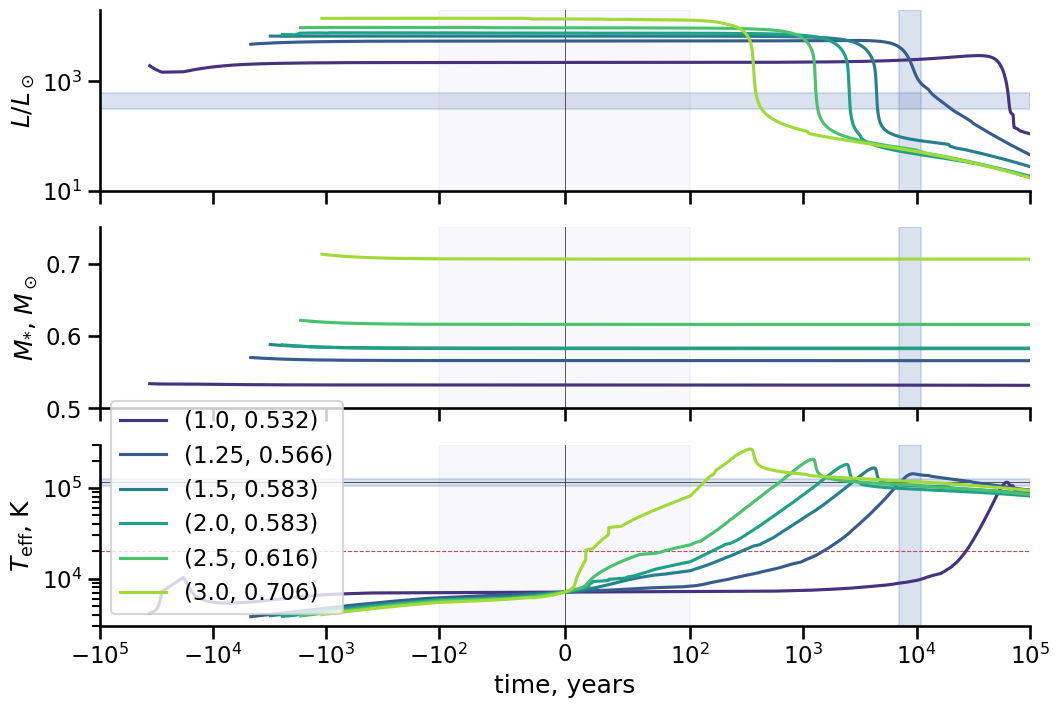

In [159]:
with sns.color_palette("viridis", n_colors=len(tabs)):
    fig, [axL, axM, ax] = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
    ax.axhspan(1000 * (T - dT), 1000 * (T + dT), color="b", alpha=0.2)
    ax.axhline(1000 * T, color="k", lw=0.5)
    ax.axhline(20000, color="r", ls="--", lw=0.8)
    
    axL.axhspan(310, 600, color="b", alpha=0.2)
    for axx in axL, axM, ax:
        axx.axvline(0.0, color="k", lw=0.5)
        axx.axvspan(-100, 100, color="m", alpha=0.05)
        axx.axvspan(7e3, 11e3, color="b", alpha=0.2)
    for data in tabs:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        data["Teff"] = 10**data["logTeff"]
        data["L"] = 10**data["logL"]
        data["Mdot"] = 10**data["log(-dM/dt)"]
        ax.plot(
            "t", "Teff",
            data=data, label=label,
        )
        axM.plot(
            "t", "Mstar",
            data=data, label=label,
        )
        axL.plot(
            "t", "L",
            data=data,
        )
    ax.legend()
    ax.set(
        xlabel="time, years",
        ylabel=r"$T_{\mathrm{eff}}$, K",
        xlim=[-100000, 100000],
        ylim=[3000, 3e5],
    )
    ax.set_xscale("symlog", linthresh=100)
    ax.set_yscale("log")
    axL.set(
        ylim=[None, None],
        ylabel=r"$L / L_\odot$",
    )
    axL.set_yscale("log")
    axL.set_ylim(10, 2e4)
    axM.set(
        ylim=[0.5, 0.75],
        ylabel=r"$M_{*}$, $M_\odot$",
        yscale="linear",
    )
    sns.despine()

So, this shows the problem with the (1.0, 0.532) model. It takes far too long to heat up to < 1e5 K.

On the other hand, the (1.25, 0.566) model is more or less the right T at 8000 years, but is several times too luminous (2000 Lsun)

In [46]:
def make_table_of_times(tabs, Teff):
    logTeff = np.log10(Teff)
    tTkey = f"t({Teff})"
    rslts = {
        "Mi": [],
        "Mf": [],
        tTkey: [],
        "t_cross": [],
        "t_tr": [],
    }
    for data in tabs:
        Mi, Mf = extract_masses(data)
        rslts["Mi"].append(Mi)
        rslts["Mf"].append(Mf)
        # First time to reach given Teff
        mask = data["logTeff"] >= logTeff
        tT = data[mask]["t"].min()
        rslts[tTkey].append(tT)
        # Time to cross to maximum Teff
        icross = data["logTeff"].argmax()
        rslts["t_cross"].append(data[icross]["t"])
        # Transition time before t = 0
        rslts["t_tr"].append(-data["t"].min())
    return Table(rslts)

In [47]:
times = make_table_of_times(tabs, 75000)

In [48]:
times

Mi,Mf,t(75000),t_cross,t_tr
float64,float64,float64,float64,float64
1.0,0.532,49707.8002,62954.7293,36100.5608
1.25,0.566,5246.1258,9299.4885,4611.4263
1.5,0.583,1788.4258,4215.0691,3099.6772
2.0,0.583,889.0794,2404.3056,2427.0822
2.5,0.616,396.8848,1215.2703,1670.3951
3.0,0.706,94.5854,339.101,1083.7751


### HR diagram with kinematic ages

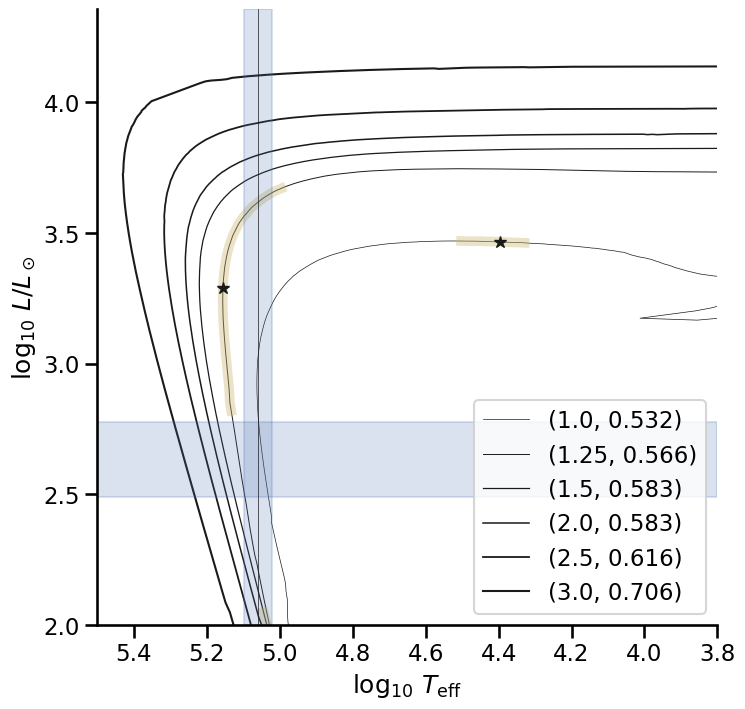

In [180]:
fig, ax = plt.subplots(figsize=(8, 8))
#ax.axvspan(4.7, 5.0, 0.6, 0.9, color="k", alpha=0.1)

ax.axvspan(np.log10(1000 * (T - dT)), np.log10(1000 * (T + dT)), color="b", alpha=0.2)
ax.axvline(np.log10(1000 * T), color="k", lw=0.5)
ax.axhspan(np.log10(310), np.log10(600), color="b", alpha=0.2)

lw = 0.5
tkin = 8200.0
# logTion = 4.3
logTion = np.log10(15_000)
for data in tabs:
    try:
        Mi, Mf = extract_masses(data)
        label = f"({Mi}, {Mf})"
    except:
        continue
    ax.plot(
        "logTeff", "logL",
        data=data, label=label,
        zorder=-100, c="k", lw=lw,
    )
    t0 = np.interp(logTion, data["logTeff"], data["t"])
    logT = np.interp(tkin + t0, data["t"], data["logTeff"])
    logL = np.interp(tkin + t0, data["t"], data["logL"])
    ax.plot(logT, logL, "*", c="k")
    m = (data["t"] > t0 + tkin/1.5) & (data["t"] < t0 + tkin*1.5)
    ax.plot(
        "logTeff", "logL",
        data=data[m], label="_nolabel_",
        zorder=-100, c="y", lw=7, alpha=0.4,
    )
    lw += 0.2
    
ax.legend()
ax.set(
    ylabel="$\log_{10}\, L/L_\odot$",
    xlabel="$\log_{10}\, T_{\mathrm{eff}}$",
    xlim=[5.5, 3.8],
    ylim=[2.0, None],
)
sns.despine()
fig.savefig("hr-planetaries.pdf")
None

So, when we look at it like this, then none of the models seem to work

## Now try the MIST tracks

In [289]:
mist_files = sorted((datadir / "MIST").glob("*.track.eep"))
mist_files

[PosixPath('../cspn-tables/MIST/0010000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0010500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0011000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0011500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0012000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0012500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0013000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0013500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0014000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0014500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015200M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015400M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015600M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015800M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016200M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016400M.track.eep'),
 PosixPath('../cspn-tables/M

In [290]:
mist_tables = [
    Table.read(p, format="ascii.commented_header", 
               guess=False, fast_reader=False, header_start=-1)
    for p in mist_files
]

Significant rows correspond to `EEP_number - 1` (Equivalent evolutionary points)

In [291]:
iAGB = 808 - 1
iPost = 1409 - 1
iWD = 1710 - 1

### Masses of the models

Initial masses

In [292]:
m_init = [np.round(tab["star_mass"][0], 4) for tab in mist_tables]
m_init

[1.0,
 1.05,
 1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.52,
 1.54,
 1.56,
 1.58,
 1.6,
 1.62,
 1.64,
 1.66,
 1.68,
 1.7]

Final masses

In [293]:
m_agb = [np.round(tab["star_mass"][iAGB], 4) for tab in mist_tables]
m_post = [np.round(tab["star_mass"][iPost], 4) for tab in mist_tables]
m_wd = [np.round(tab["star_mass"][iWD], 4) for tab in mist_tables]

In [294]:
mass_tab = Table({
    "Initial": m_init,
    "AGB": m_agb,
    "Post-AGB": m_post,
    "Final": m_wd,
})

In [295]:
mass_tab["Label"] = [f"{_mi:.2f}, {_mf:.4f}" for _mi, _, _, _mf in mass_tab]

In [296]:
mass_tab

Initial,AGB,Post-AGB,Final,Label
float64,float64,float64,float64,str12
1.0,0.9456,0.5989,0.5398,"1.00, 0.5398"
1.05,0.9992,0.6085,0.5423,"1.05, 0.5423"
1.1,1.0525,0.6126,0.5459,"1.10, 0.5459"
1.15,1.1051,0.6124,0.5478,"1.15, 0.5478"
1.2,1.1574,0.6261,0.5505,"1.20, 0.5505"
1.25,1.2096,0.6128,0.5528,"1.25, 0.5528"
1.3,1.2616,0.6319,0.5558,"1.30, 0.5558"
1.35,1.3134,0.6319,0.5581,"1.35, 0.5581"
1.4,1.365,0.63,0.5616,"1.40, 0.5616"


In [297]:
mist_tab = mist_tables[-1]

In [298]:
mist_tab.meta

{'comments': ['MIST version number  = 1.2',
  'MESA revision number =     7503',
  '--------------------------------------------------------------------------------------',
  'Yinit        Zinit   [Fe/H]   [a/Fe]  v/vcrit',
  '0.2703  1.42857E-02     0.00     0.00     0.40',
  '--------------------------------------------------------------------------------------',
  'initial_mass   N_pts   N_EEP   N_col   phase        type',
  '1.7000000000E+00    1710      10      77     YES    low-mass',
  'EEPs:        1     202     353     454     605     631     707     808    1409    1710',
  '--------------------------------------------------------------------------------------',
  '1                               2                               3                               4                               5                               6                               7                               8                               9                              10                            

In [299]:
mist_tab.colnames

['star_age',
 'star_mass',
 'star_mdot',
 'he_core_mass',
 'c_core_mass',
 'o_core_mass',
 'log_L',
 'log_L_div_Ledd',
 'log_LH',
 'log_LHe',
 'log_LZ',
 'log_Teff',
 'log_abs_Lgrav',
 'log_R',
 'log_g',
 'log_surf_z',
 'surf_avg_omega',
 'surf_avg_v_rot',
 'surf_num_c12_div_num_o16',
 'v_wind_Km_per_s',
 'surf_avg_omega_crit',
 'surf_avg_omega_div_omega_crit',
 'surf_avg_v_crit',
 'surf_avg_v_div_v_crit',
 'surf_avg_Lrad_div_Ledd',
 'v_div_csound_surf',
 'surface_h1',
 'surface_he3',
 'surface_he4',
 'surface_li7',
 'surface_be9',
 'surface_b11',
 'surface_c12',
 'surface_c13',
 'surface_n14',
 'surface_o16',
 'surface_f19',
 'surface_ne20',
 'surface_na23',
 'surface_mg24',
 'surface_si28',
 'surface_s32',
 'surface_ca40',
 'surface_ti48',
 'surface_fe56',
 'log_center_T',
 'log_center_Rho',
 'center_degeneracy',
 'center_omega',
 'center_gamma',
 'mass_conv_core',
 'center_h1',
 'center_he4',
 'center_c12',
 'center_n14',
 'center_o16',
 'center_ne20',
 'center_mg24',
 'center_si28'

In [300]:
mist_tab.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

### Plot the MIST time evolution, compared with MB

In [301]:
from astropy.constants import R_sun
import astropy.units as u

In [302]:
R_sun.cgs.value

69570000000.0

In [303]:
(1 * u.km).cgs.value

100000.0

Range of allowed kinematic timescales

In [304]:
tkin_min, tkin, tkin_max = 7.5e3, 9e3, 10.5e3

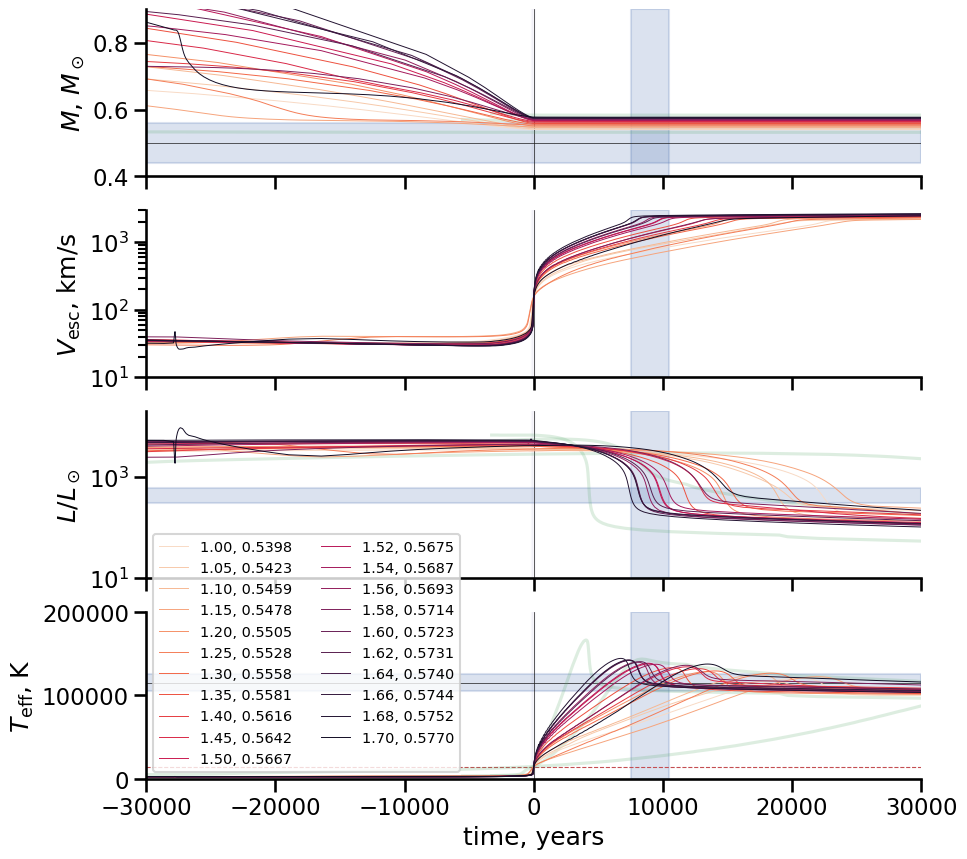

In [305]:
with sns.color_palette("rocket_r", n_colors=len(mist_tables)):

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
    axM, axV, axL, ax = axes
    ax.axhspan(1000 * (T - dT), 1000 * (T + dT), color="b", alpha=0.2)
    ax.axhline(1000 * T, color="k", lw=0.5)
    ax.axhline(15_000, color="r", ls="--", lw=0.8)
    
    axL.axhspan(310, 600, color="b", alpha=0.2)

    axM.axhline(0.5, color="k", lw=0.5)
    axM.axhspan(0.5 - 0.06, 0.5 + 0.06, color="b", alpha=0.2)
    
    for axx in axes:
        axx.axvline(0.0, color="k", lw=0.5)
        axx.axvspan(-100, 100, color="m", alpha=0.05)
        axx.axvspan(tkin_min, tkin_max, color="b", alpha=0.2)
    
    # Miller Bertolami as pale lines
    alphaMB = 0.2
    for data in tabs[:3]:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        data["Teff"] = 10**data["logTeff"]
        data["L"] = 10**data["logL"]
        data["Mdot"] = 10**data["log(-dM/dt)"]
        # Time zerop point is where T_eff = 20,000 K
        t00 = np.interp(logTion, data["logTeff"], data["t"])
        age = data["t"] - t00
        ax.plot(
            age, data["Teff"],
            # label=label,
            label=None,
            alpha=alphaMB,
            color="g",
        )
        axM.plot(
            age, data["Mstar"],
            # label=label,
            label=None,
            alpha=alphaMB,
            color="g",
         )
        axL.plot(
            age, data["L"],
            label=None,
            alpha=alphaMB,
            color="g",
         )
    
    # MIST tracks
    mist_plot_kws = dict(lw=0.7)
    for label, data in zip(mass_tab["Label"], mist_tables):
        # Where MIST says that post-AGB starts
        t0 = data["star_age"][iPost]
        # But for MB comparison we want consistent time zero point 
        # Choose where T_eff = 20,000 K
        t00 = np.interp(logTion, data["log_Teff"], data["star_age"])
        age = data["star_age"] - t00
        ax.plot(
            age,
            10**data["log_Teff"],
            label=label,
            **mist_plot_kws,
        )
        # axMd.plot(
        #     age,
        #     -data["star_mdot"],
        #     **mist_plot_kws,
        # )
        axM.plot(
            age,
            data["star_mass"],
            **mist_plot_kws,
        )
        axL.plot(
            age,
            10**data["log_L"],
            **mist_plot_kws,
        )
        g = 10**data["log_g"] * u.cm / u.s **2
        R = 10**data["log_R"] * R_sun
        v_esc = np.sqrt(2 * g * R).to_value(u.km / u.s)
        axV.plot(
            age,
            # data["v_wind_Km_per_s"],
            v_esc,
            **mist_plot_kws,
        )
            
    ax.legend(ncol=2, fontsize="xx-small")
    ax.set(
        xlabel="time, years",
        ylabel=r"$T_{\mathrm{eff}}$, K",
        xlim=[-30_000, 30_000],
        ylim=[0, 2e5],
    )
    # ax.set_xscale("symlog", linthresh=3000)
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    axL.set_ylabel(r"$L / L_\odot$")
    axL.set_yscale("log")
    axL.set_ylim(10, 2e4)
    axM.set(
        ylim=[0.4, 0.9],
        ylabel=r"$M$, $M_\odot$",
        yscale="linear",
    )
    axV.set(
        ylim=[10, 3000],
        ylabel=r"$V_\mathrm{esc}$, km/s",
        yscale="log",
    )
    sns.despine()

### MIST Kiel diagram

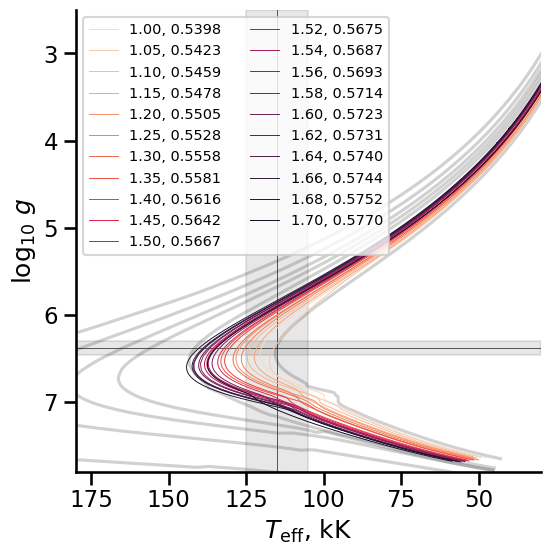

In [306]:
with sns.color_palette("rocket_r", n_colors=len(mist_tables)):

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axvspan(T - dT, T + dT, color="k", alpha=0.1)
    ax.axvline(T, color="k", lw=0.5)
    ax.axhspan(log_g - dlog_g, log_g + dlog_g, color="k", alpha=0.1)
    ax.axhline(log_g, color="k", lw=0.5)
    for data in tabs:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        ax.plot(
            0.001 * 10**data["logTeff"], data["logg"],
            label=None, alpha=alphaMB, color="k",
        )
    for data, label in zip(mist_tables, mass_tab["Label"]):
        ax.plot(
            0.001 * 10**data["log_Teff"],
            data["log_g"],
            label=label,
            **mist_plot_kws,
        )
    
    ax.legend(ncol=2, fontsize="xx-small")
    ax.set(
        ylabel=r"$\log_{10}\, g$",
        xlabel=r"$T_{\mathrm{eff}}$, kK",
        ylim=[7.8, 2.5],
        xlim=[180, 30],
    )
    sns.despine()
...;

### MIST HR diagram

Use tighter bounds on the kinematic age: $8.2 \pm 0.4$ as in the Table

In [307]:
tkin_min, tkin, tkin_max = 7.8e3, 8.2e3, 8.6e3

In [331]:
def limits(a, b, ax):
    if a>b : a, b = b, a
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    return ((y-ymin)/dy for y in (a, b))


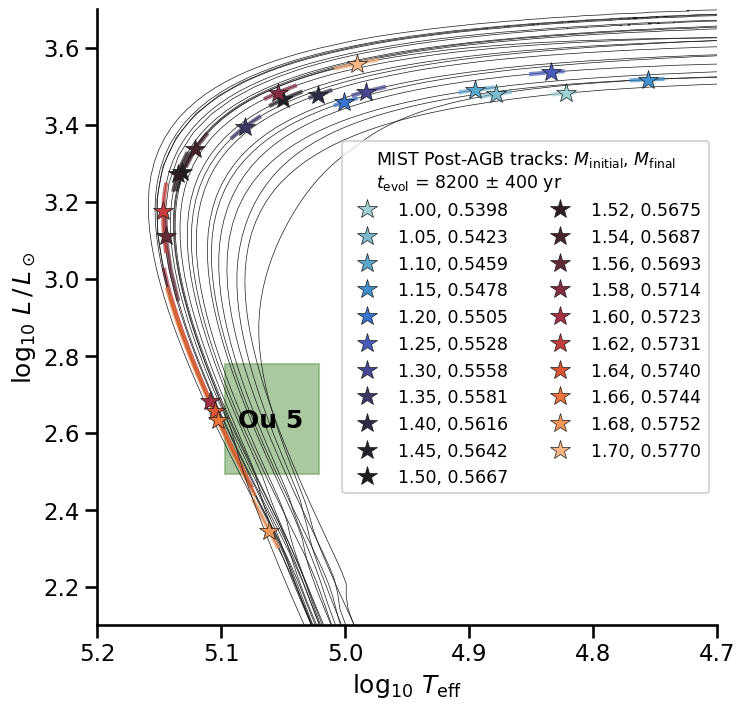

In [388]:
with sns.color_palette("icefire", n_colors=len(mist_tables)):
    fig, ax = plt.subplots(figsize=(8, 8))
    #ax.axvspan(4.7, 5.0, 0.6, 0.9, color="k", alpha=0.1)
    
    # ax.axvline(np.log10(1000 * T), color="k", lw=0.5)
    # ax.axhspan(np.log10(310), np.log10(600), color="b", alpha=0.1)
    
    lw = 0.5
    logTion = np.log10(10_000)
    
    # for data in tabs:
    #     try:
    #         Mi, Mf = extract_masses(data)
    #         label = f"({Mi}, {Mf})"
    #     except:
    #         continue
    #     ax.plot(
    #         "logTeff", "logL",
    #         data=data, label="_nolabel_",
    #         zorder=-100, c="0.95", lw=lw,
    #     )
    #     t0 = np.interp(logTion, data["logTeff"], data["t"])
    #     logT = np.interp(tkin + t0, data["t"], data["logTeff"])
    #     logL = np.interp(tkin + t0, data["t"], data["logL"])
    #     ax.plot(logT, logL, "*", c="0.9")
    #     m = (data["t"] > t0 + tkin_min) & (data["t"] < t0 + tkin_max)
    #     ax.plot(
    #         "logTeff", "logL",
    #         data=data[m], label="_nolabel_",
    #         zorder=-100, c="y", lw=7, alpha=0.2,
    #     )
    #     lw += 0.2
    
    lw = 0.5
    for data, label in zip(mist_tables, mass_tab["Label"]):
        # Plot the evolutionary track
        ax.plot(
            "log_Teff", "log_L",
            data=data, label="_nolabel_",
            zorder=-100, c="k", lw=lw,
        )
        # Calculate zero point for ages: T_eff > 15_000 K
        t00 = np.interp(logTion, data["log_Teff"], data["star_age"])
        age = data["star_age"] - t00
        logT = np.interp(tkin + t00, data["star_age"], data["log_Teff"])
        logL = np.interp(tkin + t00, data["star_age"], data["log_L"])
        # Put symbol at kinematic age
        line, = ax.plot(logT, logL, "*", markersize=15, mew=0.5, mec="k", label=label)
        m = (data["star_age"] > t00 + tkin_min) & (data["star_age"] < t00 + tkin_max)
        # Indicate uncertainty range in kinematic age
        ax.plot(
            "log_Teff", "log_L",
            data=data[m], label="_nolabel_",
            zorder=-100, c=line.get_color(), lw=3, alpha=0.7,
        )
        # lw += 0.1
        ...

    # ou5_text = "\n".join([
    #     "Ou 5",
    #     r"$T = 100$ to 115 kK",
    #     r"$L = 300$ to 660 L$_\odot$",
    # ])
    ou5_text = "Ou 5"
    ax.text(3 + np.log10(T), np.log10(430), ou5_text, fontweight="black", ha="center", va="center")
    title = (
        r"MIST Post-AGB tracks: $M_\mathrm{initial}$, $M_\mathrm{final}$"
        "\n"
        r"$t_\mathrm{evol}$ = 8200 $\pm$ 400 yr"
    )
    ax.legend(
        ncol=2, 
        loc="right",
        fontsize="x-small",
        title=title, 
        title_fontsize="x-small",
    )
    ax.set(
        ylabel=r"$\log_{10}\, L\,/\,L_\odot$",
        xlabel=r"$\log_{10}\, T_{\mathrm{eff}}$",
        xlim=[5.2, 4.7],
        ylim=[2.1, 3.7],
    )
    ax.axvspan(
        np.log10(1000 * (T - dT)), np.log10(1000 * (T + dT)),
        *limits(np.log10(310), np.log10(600), ax),
        color="xkcd:dull green", alpha=0.6, zorder=-1000,
    )

    sns.despine()
    fig.savefig("hr-mist-ou5.pdf", bbox_inches="tight")
...;

In [309]:
Table.read.help("ascii.commented_header")

Table.read(format='ascii.commented_header') documentation

Read the input ``table`` and return the table.  Most of the default behavior for
various parameters is determined by the ``format`` argument.

Help on the ``read()`` function arguments is available as shown in this example::

  from astropy.io import ascii
  ascii.read.help()  # Common help for all formats
  ascii.read.help("html")  # Common help plus "html" format-specific args

See also:

- https://docs.astropy.org/en/stable/io/ascii/
- https://docs.astropy.org/en/stable/io/ascii/read.html

Parameters
----------
table : str, file-like, list, `pathlib.Path` object
    Input table as a file name, file-like object, list of string[s],
    single newline-separated string or `pathlib.Path` object.
guess : bool
    Try to guess the table format. Defaults to None.
format : str, `~astropy.io.ascii.BaseReader`
    Input table format
delimiter : str
    Column delimiter string
comment : str
    Regular expression defining a comment line